In [1]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot as plt
import h5py
from keras import callbacks
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

Using TensorFlow backend.
C:\Users\priya\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\priya\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\priya\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\priya\Anaconda3\envs\te

In [10]:
def FeatureSelection(myinputX, myinputY):

    labels = np.array(myinputY).astype(int)
    inputX = np.array(myinputX)
    
    #Random Forest Model
    model = RandomForestClassifier(random_state = 0)
    model.fit(inputX,labels)
    importances = model.feature_importances_
    
    
    #Plotting the Features agains their importance scores
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
    plt.figure(figsize = (10,5))
    plt.title("Feature importances (y-axis) vs Features IDs(x-axis)")
    plt.bar(range(inputX.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(inputX.shape[1]), indices)
    plt.xlim([-1, inputX.shape[1]])
    plt.show()
    
    # Selecting top featueres which have higher importance values = here we can find "12" features
    #as we can see in the next step
    newX = myinputX.iloc[:,model.feature_importances_.argsort()[::-1][:25]]
   # Converting the X dataframe into tensors
    myX = newX.to_numpy()
    myY = labels
    #print("myY is havinglabels\n\n",myX)

   
    return myX,myY

In [11]:
def DataLoading (mypath):
    print ("Loading the data")
    dataframe = pd.read_csv(mypath,header = None,engine = 'python',sep=",")
    return dataframe

def DataPreprocessing(mydataframe):
    
    # Dropping the duplicates
    recordcount = len(mydataframe)
    print ("Original number of records in the training dataset before removing duplicates is: " , recordcount)
    mydataframe.drop_duplicates(subset=None, inplace=True)  # Python command to drop duplicates
    newrecordcount = len(mydataframe)
    print ("Number of records in the training dataset after removing the duplicates is :", newrecordcount,"\n")

    #Dropping the labels to a different dataset which is used to train the recurrent neural network classifier
    df_X = mydataframe.drop(mydataframe.columns[41],axis=1,inplace = False)
    df_Y = mydataframe.drop(mydataframe.columns[0:41],axis=1, inplace = False)

    # Convert Categorial data to the numerical data for the efficient classification
    df_X[df_X.columns[1:4]] = df_X[df_X.columns[1:4]].stack().rank(method='dense').unstack()
        
    a=[]
    for x in df_Y[41]:
        if(x=='normal'):
            a.append(0)
        elif(x=='neptune'or x=='back' or x=='land'or x=='pod'or x=='smurf'or x=='teardrop'or x=='mailbomb'or x=='apache2'or x=='processtable'or x=='udpstorm'):
            a.append(1)
        elif(x=='ipsweep' or x=='nmap' or x=='portsweep'or x=='satan'or x=='mscan'or x=='saint'):
            a.append(2)
        elif(x=='ftp_write' or x=='guess_passwd' or x=='imap'or x=='multihop'or x=='phf'or x=='spy'or x=='warezclient'
             or x=='warezmaster'or x=='sendmail'or x=='named'or x=='snmpgetatack'or x=='snmpguess'or x=='worm'or x=='xlock'or x=='xsnoop'):
            a.append(3)
        elif(x=='httptunnel' or x=='buffer_overflow' or x=='loadmodule'or x=='perl'or x=='rootkit'or x=='ps'or x=='sqlattack'or x=='xterm'):
            a.append(4)
    
    del df_Y[41]   
    df_Y[41]=a
       
    y_train1 = np.array(df_Y[41])
    
    Y= to_categorical(y_train1)
    print(Y)
    #converting input data into float which is requried in the future stage of building in the network
    df_X = df_X.loc[:,df_X.columns[0:41]].astype(float)

    '''# Normal is "1 0" and the abnormal is "0 1"
    df_Y.columns = ["y1"]
    df_Y.loc[:,('y2')] = df_Y['y1'] ==0
    df_Y.loc[:,('y2')] = df_Y['y2'].astype(int)
    '''

    
    return df_X,Y

Loading the IDS Data
Loading the data
Data Preprocessing of loaded IDS Data
Original number of records in the training dataset before removing duplicates is:  125973
Number of records in the training dataset after removing the duplicates is : 125973 

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Performing the Feature Selection on train data set


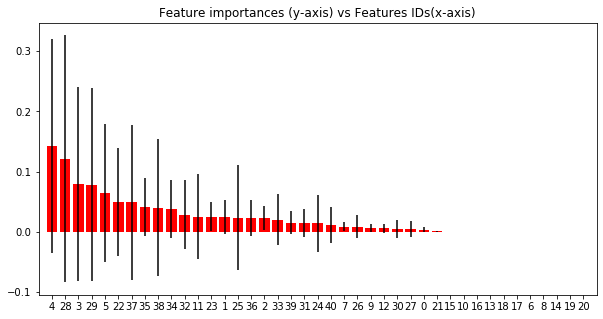

 X shape is : (125973, 25)
 Y shape is : (125973, 5)


In [12]:
print ("Loading the IDS Data")
data_path = "KDDTrain+_2.csv"
dataframe = DataLoading(data_path)

print ("Data Preprocessing of loaded IDS Data")
data_X, data_Y = DataPreprocessing(dataframe)

print ("Performing the Feature Selection on train data set")
reduced_X,reduced_Y = FeatureSelection(data_X,data_Y)


print (" X shape is :", reduced_X.shape)
print (" Y shape is :", reduced_Y.shape)

In [7]:
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
red_X=np.reshape(reduced_X, (reduced_X.shape[0],1,reduced_X.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(red_X, reduced_Y, test_size = 0.3, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(88181, 1, 25)
(37792, 1, 25)
(88181, 5)
(37792, 5)


In [8]:
import keras.backend as K
from keras.metrics import categorical_accuracy
batch_size = 32
model = Sequential()
model.add(GRU(4,input_dim=25))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(Dense(5))
model.add(Activation('softmax'))


c:\users\priya\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
c:\users\priya\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(4, input_shape=(None, 25))`
  """


In [23]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=50, validation_data=(X_test, y_test),verbose=1)

Train on 88181 samples, validate on 37792 samples
Epoch 1/50
88181/88181 [==============================] - 16s 186us/step - loss: 0.6642 - categorical_accuracy: 0.8052 - val_loss: 0.3883 - val_categorical_accuracy: 0.8789
Epoch 2/50
88181/88181 [==============================] - 13s 152us/step - loss: 0.3846 - categorical_accuracy: 0.8868 - val_loss: 0.3073 - val_categorical_accuracy: 0.8974
Epoch 3/50
88181/88181 [==============================] - 13s 152us/step - loss: 0.3485 - categorical_accuracy: 0.9026 - val_loss: 0.2934 - val_categorical_accuracy: 0.9272
Epoch 4/50
88181/88181 [==============================] - 13s 151us/step - loss: 0.3418 - categorical_accuracy: 0.9133 - val_loss: 0.2804 - val_categorical_accuracy: 0.9379
Epoch 5/50
88181/88181 [==============================] - 14s 157us/step - loss: 0.3280 - categorical_accuracy: 0.9178 - val_loss: 0.2666 - val_categorical_accuracy: 0.9432
Epoch 6/50
88181/88181 [==============================] - 14s 161us/step - loss: 0.31

Epoch 48/50
88181/88181 [==============================] - 14s 160us/step - loss: 0.1595 - categorical_accuracy: 0.9625 - val_loss: 0.1198 - val_categorical_accuracy: 0.9744
Epoch 49/50
88181/88181 [==============================] - 14s 158us/step - loss: 0.1598 - categorical_accuracy: 0.9627 - val_loss: 0.1194 - val_categorical_accuracy: 0.9744
Epoch 50/50
88181/88181 [==============================] - 14s 159us/step - loss: 0.1565 - categorical_accuracy: 0.9635 - val_loss: 0.1149 - val_categorical_accuracy: 0.9755


In [24]:
loss, accuracy = model.evaluate(X_test, y_test)

print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

37792/37792 [==============================] - 2s 56us/step

Loss: 0.11, Accuracy: 97.55%


In [11]:
import tensorflow as tf
import keras
from keras.layers import Dense, Input
from keras.models import Sequential
from keras.callbacks import Callback
from sklearn.metrics import recall_score, classification_report
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# callback to find metrics at epoch end
class Metrics(Callback):
    def __init__(self, x, y):
        self.x = x
        self.y = y if (y.ndim == 5 or y.shape[1] == 5) else np.argmax(y, axis=1)
        self.reports = []

    def on_epoch_end(self, epoch, logs={}):
        y_hat = np.asarray(self.model.predict(self.x))
        y_hat = np.where(y_hat > 0.5, 1, 0) if (self.y.ndim == 1 or y_hat.shape[1] == 5)  else np.argmax(y_hat, axis=1)
        report = classification_report(self.y,y_hat,output_dict=True)
        self.reports.append(report)
        return

    # Utility method
    def get(self, metrics, of_class):
        return [report[str(of_class)][metrics] for report in self.reports]


metrics = Metrics(X_train,y_train)
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=50,validation_data=(X_test, y_test),callbacks=[metrics],verbose=1)

'''
plt.close('all')
for m in ['recall', 'precision', 'f1-score']:
    for c in [0,1,2]:
        plt.plot(metrics_milticlass.get(m,c), label='Class {0} {1}'.format(c,m))

plt.legend(loc='lower right')
plt.show()
'''

Train on 88181 samples, validate on 37792 samples
Epoch 1/50
88181/88181 [==============================] - 18s 207us/step - loss: 0.3200 - acc: 0.8860 - val_loss: 0.2768 - val_acc: 0.8983


c:\users\priya\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\priya\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/50
88181/88181 [==============================] - 17s 194us/step - loss: 0.2763 - acc: 0.9188 - val_loss: 0.2116 - val_acc: 0.9551
Epoch 3/50
88181/88181 [==============================] - 18s 199us/step - loss: 0.2395 - acc: 0.9384 - val_loss: 0.1851 - val_acc: 0.9595
Epoch 4/50
88181/88181 [==============================] - 16s 176us/step - loss: 0.2261 - acc: 0.9418 - val_loss: 0.1739 - val_acc: 0.9633
Epoch 5/50
88181/88181 [==============================] - 15s 176us/step - loss: 0.2164 - acc: 0.9451 - val_loss: 0.1601 - val_acc: 0.9675
Epoch 6/50
88181/88181 [==============================] - 16s 177us/step - loss: 0.2062 - acc: 0.9508 - val_loss: 0.1557 - val_acc: 0.9688
Epoch 7/50
88181/88181 [==============================] - 18s 209us/step - loss: 0.2015 - acc: 0.9521 - val_loss: 0.1576 - val_acc: 0.9682
Epoch 8/50
88181/88181 [==============================] - 17s 193us/step - loss: 0.2021 - acc: 0.9510 - val_loss: 0.1502 - val_acc: 0.9696
Epoch 9/50
88181/88181 [===

"\nplt.close('all')\nfor m in ['recall', 'precision', 'f1-score']:\n    for c in [0,1,2]:\n        plt.plot(metrics_milticlass.get(m,c), label='Class {0} {1}'.format(c,m))\n\nplt.legend(loc='lower right')\nplt.show()\n"

In [13]:
loss,accuracy=model.evaluate(X_test,y_test)
print("Loss=",loss,"\nAcuracy=",accuracy*100)

37792/37792 [==============================] - 2s 55us/step
Loss= 0.12430830353714847 
Acuracy= 97.47830228619814


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred.round(), labels=[0,1,2,3,4]))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98     20083
           1       0.99      0.98      0.98     13825
           2       1.00      0.94      0.97      3540
           3       0.00      0.00      0.00       327
           4       0.00      0.00      0.00        17

   micro avg       0.98      0.97      0.97     37792
   macro avg       0.59      0.58      0.59     37792
weighted avg       0.97      0.97      0.97     37792
 samples avg       0.97      0.97      0.97     37792



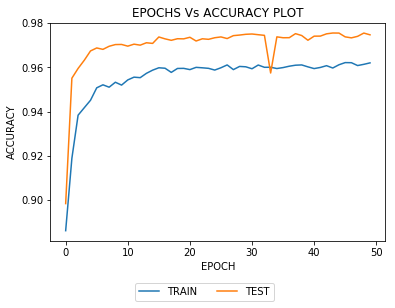

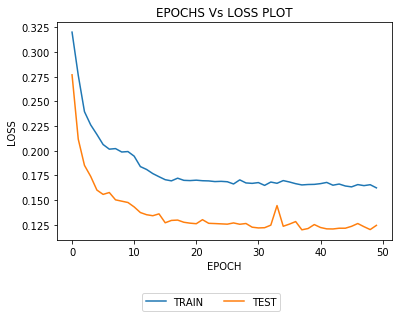

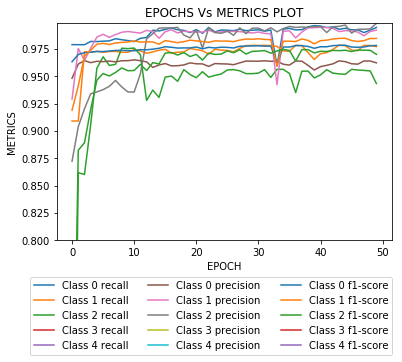

In [39]:
# summarize history for accuracy
plt.plot(history.history['acc'],label='TRAIN')
plt.plot(history.history['val_acc'],label='TEST')
plt.title('EPOCHS Vs ACCURACY PLOT')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.legend(loc='lower center',bbox_to_anchor=(0.46,-0.30),ncol=2)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],label='TRAIN')
plt.plot(history.history['val_loss'],label='TEST')
plt.title('EPOCHS Vs LOSS PLOT')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(loc='lower center',bbox_to_anchor=(0.46,-0.35),ncol=2)
plt.show()


plt.close('all')
for m in ['recall', 'precision', 'f1-score']:
    for c in [0,1,2,3,4]:
        plt.plot(metrics.get(m,c), label='Class {0} {1}'.format(c,m))
plt.ylabel('METRICS')
plt.xlabel('EPOCH')
plt.title('EPOCHS Vs METRICS PLOT')
plt.legend(loc='lower center',bbox_to_anchor=(0.46,-0.55),ncol=3)
#plt.xlim(1.3,4)
plt.ylim(0.8,0.999)
plt.show()


In [37]:
model.save("results/multi_model.hdf5")